# Import Libraries

In [123]:
import pandas as pd

# Load Source Data

In [124]:
src_games = pd.read_csv('../data/source_data/games.csv')
src_turns = pd.read_csv('../data/source_data/turns.csv')
src_train = pd.read_csv('../data/source_data/train.csv')
src_test = pd.read_csv('../data/source_data/test.csv')

# Clean Train Dataset - I want every game to be represent by one line

In [125]:
# I get this information from woogles.io and summarise into dictionary
bots_and_scores = {'BetterBot': 268240632, 'STEEBot': 276067680, 'HastyBot': 588506671}

# Sort bots according score to define difficulity of a bot
bots_and_scores = dict(sorted(bots_and_scores.items(), key=lambda item: item[1]))

bots_and_scores

{'BetterBot': 268240632, 'STEEBot': 276067680, 'HastyBot': 588506671}

In [126]:
# First split train dataset into human players and bot players
user_df = src_train[~src_train["nickname"].isin(bots_and_scores.keys())] 
user_df = user_df.rename(
    columns={"nickname": "user_name", "score": "user_score", "rating": "user_rating"}
) 

bot_df = src_train[src_train["nickname"].isin(bots_and_scores.keys())]
bot_df = bot_df.rename(
    columns={"nickname": "bot_name", "score": "bot_score", "rating": "bot_rating"}
)

display(user_df.head())
display(bot_df.head())

,game_id,user_name,user_score,user_rating
1,1,stevy,429,1500
2,3,davidavid,440,1811
4,4,Inandoutworker,119,1473
6,5,stevy,325,1500
8,6,HivinD,378,2029


,game_id,bot_name,bot_score,bot_rating
0,1,BetterBot,335,1637
3,3,BetterBot,318,2071
5,4,BetterBot,478,1936
7,5,STEEBot,427,1844
9,6,STEEBot,427,2143


In [127]:
train = pd.merge(bot_df, user_df, on="game_id")

In [128]:
print("Source train.csv:")
display(src_train.head())

print("\nAfter merged bot and human player to one line:")
display(train.head())

Source train.csv:


,game_id,nickname,score,rating
0,1,BetterBot,335,1637
1,1,stevy,429,1500
2,3,davidavid,440,1811
3,3,BetterBot,318,2071
4,4,Inandoutworker,119,1473



After merged bot and human player to one line:


,game_id,bot_name,bot_score,bot_rating,user_name,user_score,user_rating
0,1,BetterBot,335,1637,stevy,429,1500
1,3,BetterBot,318,2071,davidavid,440,1811
2,4,BetterBot,478,1936,Inandoutworker,119,1473
3,5,STEEBot,427,1844,stevy,325,1500
4,6,STEEBot,427,2143,HivinD,378,2029


# Save main df (train & test concat - will help with feature engieneer for games and turns datasets)

In [134]:
brief_df = pd.concat([src_train, src_test], axis=0)
brief_df = brief_df.sort_values(["game_id"])

full_user_df = brief_df[~brief_df["nickname"].isin(bots_and_scores.keys())] 
full_user_df = full_user_df.rename(
    columns={"nickname": "user_name", "score": "user_score", "rating": "user_rating"}
) 

full_bot_df = brief_df[brief_df["nickname"].isin(bots_and_scores.keys())]
full_bot_df = full_bot_df.rename(
    columns={"nickname": "bot_name", "score": "bot_score", "rating": "bot_rating"}
)

main_df = pd.merge(full_bot_df, full_user_df, on="game_id")

print("train & test concat main df:")
main_df.head()

train & test concat main df:


,game_id,bot_name,bot_score,bot_rating,user_name,user_score,user_rating
0,1,BetterBot,335,1637.0,stevy,429,1500.0
1,2,BetterBot,401,2000.0,Super,488,NaN
2,3,BetterBot,318,2071.0,davidavid,440,1811.0
3,4,BetterBot,478,1936.0,Inandoutworker,119,1473.0
4,5,STEEBot,427,1844.0,stevy,325,1500.0


# Games - Feature Engineer 1

### Add bot difficulity column (1 - Low Difficulity, 2 - Medium, 3 - High)

In [135]:
def score_to_difficulty(score):
    if score == max(bots_and_scores.values()):
        return 3  # High difficulty
    elif score == min(bots_and_scores.values()):
        return 1  # Low difficulty
    else:
        return 2  # Medium difficulty

bots_difficulty = {bot: score_to_difficulty(score) for bot, score in bots_and_scores.items()}

bots_difficulty

{'BetterBot': 1, 'STEEBot': 2, 'HastyBot': 3}

In [136]:
merged_df = src_games.merge(main_df, on='game_id', how='left')
games = src_games.copy()
games['bot_dificulity'] = merged_df['bot_name'].map(bots_difficulty)

In [137]:
print("Source games.csv:")
display(src_games.head())

print("\ngames with new feature (bot_difficulty):")
display(games.head())

Source games.csv:


,game_id,first,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds
0,1,BetterBot,regular,STANDARD,1,08/26/2022 3:38,NWL20,1200,0,CASUAL,1,674.844274
1,2,Super,regular,STANDARD,1,08/10/2022 19:19,CSW21,3600,0,RATED,1,364.214418
2,3,BetterBot,regular,STANDARD,1,09/04/2022 8:04,CSW21,900,0,RATED,5,492.268262
3,4,BetterBot,regular,RESIGNED,0,09/12/2022 2:36,CSW21,3600,0,CASUAL,1,350.861141
4,5,STEEBot,regular,STANDARD,0,09/06/2022 4:31,NWL20,1200,0,CASUAL,1,642.688722



games with new feature (bot_difficulty):


,game_id,first,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds,bot_dificulity
0,1,BetterBot,regular,STANDARD,1,08/26/2022 3:38,NWL20,1200,0,CASUAL,1,674.844274,1
1,2,Super,regular,STANDARD,1,08/10/2022 19:19,CSW21,3600,0,RATED,1,364.214418,1
2,3,BetterBot,regular,STANDARD,1,09/04/2022 8:04,CSW21,900,0,RATED,5,492.268262,1
3,4,BetterBot,regular,RESIGNED,0,09/12/2022 2:36,CSW21,3600,0,CASUAL,1,350.861141,1
4,5,STEEBot,regular,STANDARD,0,09/06/2022 4:31,NWL20,1200,0,CASUAL,1,642.688722,2


# Turns - Feature Engineer 1

### Add rack_len feature to turns.csv

In [138]:
turns = src_turns.copy()
turns["rack_len"] = turns["rack"].str.len()

display(turns.head())

,game_id,turn_number,nickname,rack,location,move,points,score,turn_type,rack_len
0,1,1,BetterBot,DDEGITT,8G,DIG,10,10,Play,7.0
1,1,2,stevy,AEHOPUX,7H,HAP,18,18,Play,7.0
2,1,3,BetterBot,DEELTTU,6I,LUTE,16,26,Play,7.0
3,1,4,stevy,EMORSUX,5K,UM,16,34,Play,7.0
4,1,5,BetterBot,ACDEITU,L5,..DICATE,28,54,Play,7.0


### Add rack_usage feature to turns.csv

In [139]:
turns["rack_usage"] = turns["move"].str.len() / turns["rack_len"]
turns["rack_usage"] = turns.rack_usage.fillna(0)
turns.head()

,game_id,turn_number,nickname,rack,location,move,points,score,turn_type,rack_len,rack_usage
0,1,1,BetterBot,DDEGITT,8G,DIG,10,10,Play,7.0,0.428571
1,1,2,stevy,AEHOPUX,7H,HAP,18,18,Play,7.0,0.428571
2,1,3,BetterBot,DEELTTU,6I,LUTE,16,26,Play,7.0,0.571429
3,1,4,stevy,EMORSUX,5K,UM,16,34,Play,7.0,0.285714
4,1,5,BetterBot,ACDEITU,L5,..DICATE,28,54,Play,7.0,1.142857


# Train - Feature Engineer 1

### add mean_rack_usage to train.csv - the mean rack usage of a player in a game in the total turns

In [140]:
# caclulate mean_rack_usage for every player
mean_rack_usage = turns.groupby(['game_id', 'nickname'])['rack_usage'].mean().reset_index()

# split between human users and bot users
user_mean_rack_usage = mean_rack_usage[~mean_rack_usage["nickname"].isin(bots_and_scores.keys())]
bot_mean_rack_usage = mean_rack_usage[mean_rack_usage["nickname"].isin(bots_and_scores.keys())]
user_mean_rack_usage.rename(columns={'rack_usage': 'user_mean_rack_usage', 'nickname': 'user_name'}, inplace=True)
bot_mean_rack_usage.rename(columns={'rack_usage': 'bot_mean_rack_usage', 'nickname': 'bot_name'}, inplace=True)

# print results
print("users:")
display(user_mean_rack_usage.head())
print("\nbots:")
display(bot_mean_rack_usage.head())

users:


C:\Users\liavm\AppData\Local\Temp\ipykernel_3896\60958221.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_mean_rack_usage.rename(columns={'rack_usage': 'user_mean_rack_usage', 'nickname': 'user_name'}, inplace=True)
C:\Users\liavm\AppData\Local\Temp\ipykernel_3896\60958221.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bot_mean_rack_usage.rename(columns={'rack_usage': 'bot_mean_rack_usage', 'nickname': 'bot_name'}, inplace=True)


,game_id,user_name,user_mean_rack_usage
1,1,stevy,0.573469
3,2,Super,0.591837
5,3,davidavid,0.591837
7,4,Inandoutworker,0.418367
9,5,stevy,0.511161



bots:


,game_id,bot_name,bot_mean_rack_usage
0,1,BetterBot,0.700549
2,2,BetterBot,0.761905
4,3,BetterBot,0.626374
6,4,BetterBot,0.723810
8,5,STEEBot,0.659524


In [141]:
# Merge user_mean_rack_usage and bot_mean_rack_usage with train
train_with_user = train.merge(user_mean_rack_usage, on=['game_id', 'user_name'], how='left')
train_with_bot = train_with_user.merge(bot_mean_rack_usage, on=['game_id', 'bot_name'], how='left')

# Reorder columns
columns_order = [
    'game_id', 'bot_name', 'bot_score', 'bot_mean_rack_usage', 'bot_rating',
    'user_name', 'user_score', 'user_mean_rack_usage', 'user_rating'
]
train_reordered = train_with_bot[columns_order]

# Print Results
print("train before:")
display(train.head())
print("\ntrain after:")
display(train_reordered.head())

train before:


,game_id,bot_name,bot_score,bot_rating,user_name,user_score,user_rating
0,1,BetterBot,335,1637,stevy,429,1500
1,3,BetterBot,318,2071,davidavid,440,1811
2,4,BetterBot,478,1936,Inandoutworker,119,1473
3,5,STEEBot,427,1844,stevy,325,1500
4,6,STEEBot,427,2143,HivinD,378,2029



train after:


,game_id,bot_name,bot_score,bot_mean_rack_usage,bot_rating,user_name,user_score,user_mean_rack_usage,user_rating
0,1,BetterBot,335,0.700549,1637,stevy,429,0.573469,1500
1,3,BetterBot,318,0.626374,2071,davidavid,440,0.591837,1811
2,4,BetterBot,478,0.723810,1936,Inandoutworker,119,0.418367,1473
3,5,STEEBot,427,0.659524,1844,stevy,325,0.511161,1500
4,6,STEEBot,427,0.934066,2143,HivinD,378,0.678571,2029


In [142]:
train = train_reordered

# Turns - Feature Engineer 2

## Letter Score Feature

In [167]:
letter_points = {
    1: "AEILNORSTU",  # Letters worth 1 point
    2: "DG",          # Letters worth 2 points
    3: "BCMP",        # Letters worth 3 points
    4: "FHVWY",       # Letters worth 4 points
    5: "K",           # Letters worth 5 points
    8: "JX",          # Letters worth 8 points
    10: "QZ"          # Letters worth 10 points
}

In [168]:
letter_to_points = {letter: points for points, letters in letter_points.items() for letter in letters}

def calculate_word_score(word):
    if isinstance(word, str):  
        return sum(letter_to_points.get(letter.upper(), 0) for letter in word)
    return 0 

In [169]:
turns['letter_score'] = turns['move'].apply(calculate_word_score)
turns.head()

,game_id,turn_number,nickname,rack,location,move,points,score,turn_type,rack_len,rack_usage,letter_score
0,1,1,BetterBot,DDEGITT,8G,DIG,10,10,Play,7.0,0.428571,5
1,1,2,stevy,AEHOPUX,7H,HAP,18,18,Play,7.0,0.428571,8
2,1,3,BetterBot,DEELTTU,6I,LUTE,16,26,Play,7.0,0.571429,4
3,1,4,stevy,EMORSUX,5K,UM,16,34,Play,7.0,0.285714,4
4,1,5,BetterBot,ACDEITU,L5,..DICATE,28,54,Play,7.0,1.142857,9


## Average Letter Score Feature

### Create the feature

In [172]:
turns["average_letter_score"] = turns.letter_score / turns.move.str.len()
turns.head()

,game_id,turn_number,nickname,rack,location,move,points,score,turn_type,rack_len,rack_usage,letter_score,average_letter_score
0,1,1,BetterBot,DDEGITT,8G,DIG,10,10,Play,7.0,0.428571,5,1.666667
1,1,2,stevy,AEHOPUX,7H,HAP,18,18,Play,7.0,0.428571,8,2.666667
2,1,3,BetterBot,DEELTTU,6I,LUTE,16,26,Play,7.0,0.571429,4,1.000000
3,1,4,stevy,EMORSUX,5K,UM,16,34,Play,7.0,0.285714,4,2.000000
4,1,5,BetterBot,ACDEITU,L5,..DICATE,28,54,Play,7.0,1.142857,9,1.125000


### Research on average letter score behaivor of any different rated player

In [208]:
from scipy.stats import linregress
import matplotlib.pyplot as plt
import numpy as np
import random

In [190]:
train_sorted = train.sort_values(by="user_rating", ascending=False)
top_5_best_users = train_sorted["user_name"].drop_duplicates().iloc[:5].tolist()
top_5_worst_users = train_sorted["user_name"].drop_duplicates().iloc[-5:].tolist()

In [191]:
def get_random_game_id(user_name, turns_df):
    unique_game_ids = turns_df[turns_df["nickname"] == user_name]["game_id"].unique()
    if len(unique_game_ids) > 0:
        return random.choice(unique_game_ids)
    return None

In [199]:
selected_games = []
for user in top_5_best_users + top_5_worst_users:
    game_id = get_random_game_id(user, turns)
    if game_id:
        selected_games.append((user, game_id))
selected_games

[('Pasindu', 6017),
 ('TKC', 51814),
 ('LIMEUJIE', 26419),
 ('earth', 60213),
 ('AWFUL', 974),
 ('Mzine', 29288),
 ('isaac2', 45525),
 ('aqilfattah', 6888),
 ('Saadkhan', 32921),
 ('fawzah', 49014)]

In [201]:
filtered_selected_games = selected_games[:5]
filtered_selected_games

[('Pasindu', 6017),
 ('TKC', 51814),
 ('LIMEUJIE', 26419),
 ('earth', 60213),
 ('AWFUL', 974)]

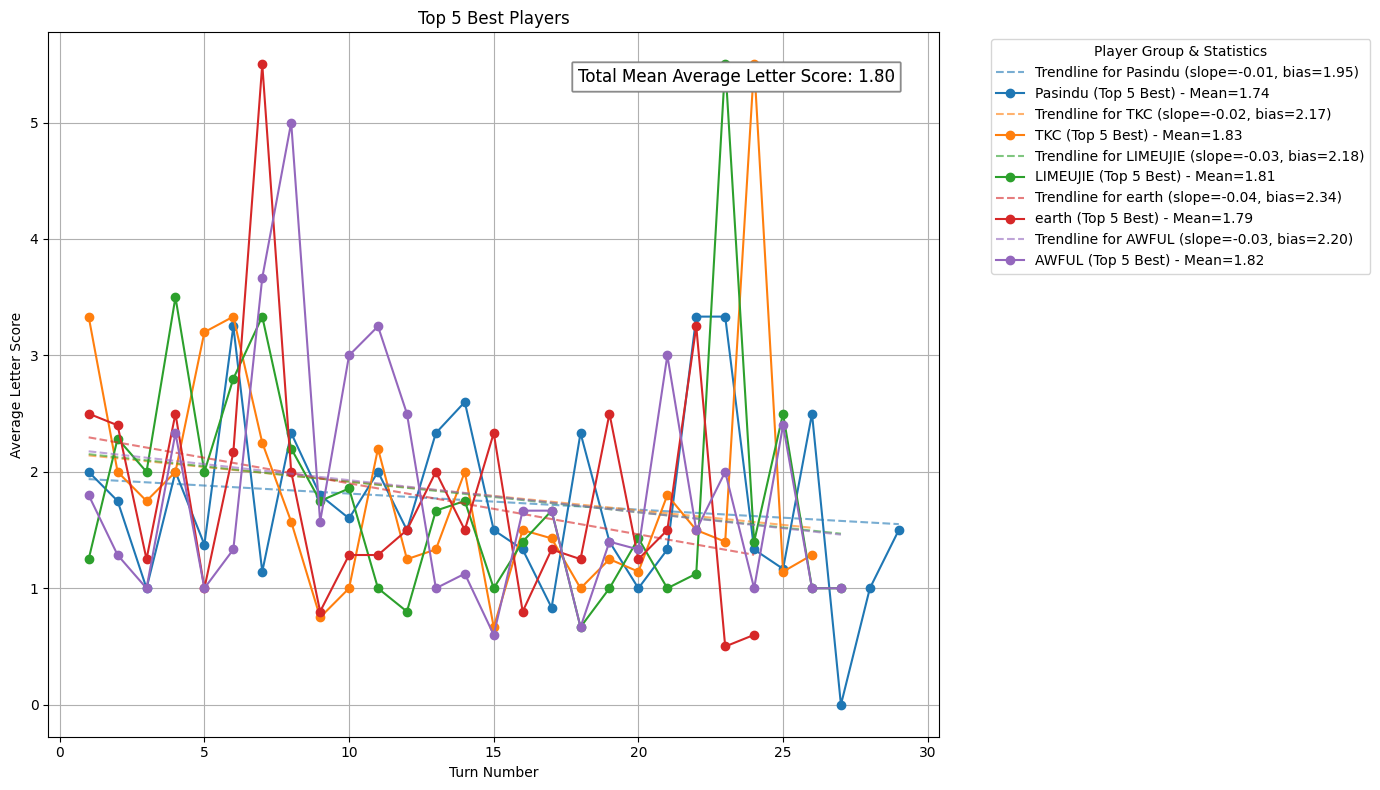

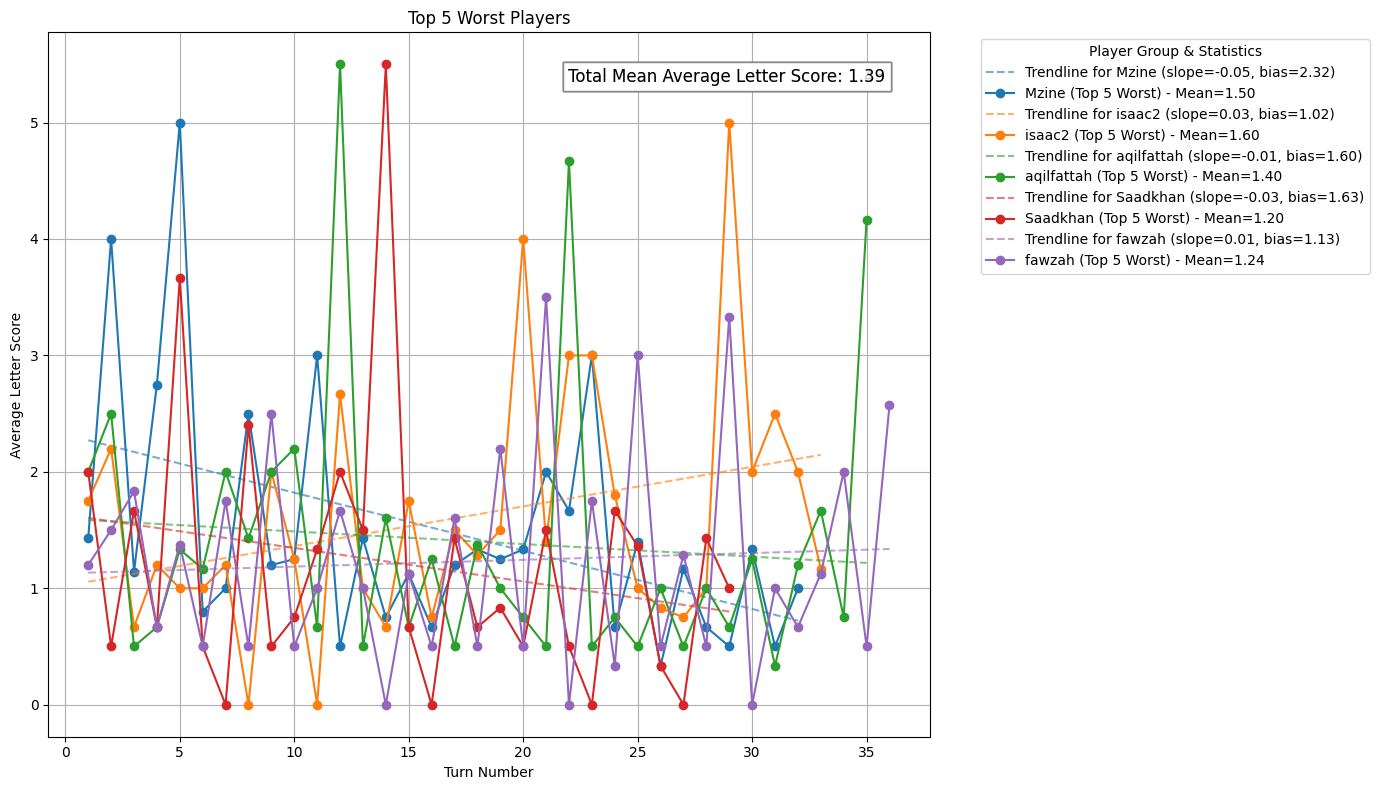

In [211]:
def plot_avergae_letter_score_during_game(selected_games, title="Average Letter Score During Selected Games"):
    plt.figure(figsize=(14, 8))
    colors = plt.cm.tab10.colors  
    all_mean_scores = [] 
    
    for i, (user, game_id) in enumerate(selected_games):
        user_turns = turns[turns["game_id"] == game_id]
        turn_numbers = user_turns["turn_number"]
        avg_scores = user_turns["average_letter_score"]

        # Calculate Mean
        mean_score = avg_scores.mean()
        all_mean_scores.append(mean_score)

        # Calculate Trendline (Linear Regression)
        slope, intercept, _, _, _ = linregress(turn_numbers, avg_scores)
        trendline = slope * turn_numbers + intercept

        # Plot the trendline
        plt.plot(
            turn_numbers,
            trendline,
            linestyle="--",
            color=colors[i % len(colors)],
            alpha=0.6,
            label=f"Trendline for {user} (slope={slope:.2f}, bias={intercept:.2f})"
        )
        
        # Plot the player's average letter score
        plt.plot(
            turn_numbers,
            avg_scores,
            label=f"{user} ({'Top 5 Best' if user in top_5_best_users else 'Top 5 Worst'}) - Mean={mean_score:.2f}",
            color=colors[i % len(colors)],
            marker="o"
        )
        
        # Calculate and display the total mean of all players
        total_mean_score = np.mean(all_mean_scores)
        plt.text(
            0.95, 0.95, f"Total Mean Average Letter Score: {total_mean_score:.2f}",
            horizontalalignment='right',
            verticalalignment='top',
            transform=plt.gca().transAxes,
            fontsize=12,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray')
        )
    
    # Customize the plot
    plt.title(title)
    plt.xlabel("Turn Number")
    plt.ylabel("Average Letter Score")
    plt.legend(title="Player Group & Statistics", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Generate the plots
plot_avergae_letter_score_during_game(selected_games[:5], title="Top 5 Best Players")
plot_avergae_letter_score_during_game(selected_games[5:], title="Top 5 Worst Players")

I conclude that higher ranked players tend to use words made up of more expensive letters.

# Train - Feature Engineer 2

## Mean Average Letter Score - Feature

In [214]:
mean_avg_letter_score = (
    turns.groupby(["game_id", "nickname"])["average_letter_score"]
    .mean()
    .reset_index()
    .rename(columns={"average_letter_score": "mean_average_letter_score"})
)

mean_avg_letter_score.head()

,game_id,nickname,mean_average_letter_score
0,1,BetterBot,2.045055
1,1,stevy,1.636905
2,2,BetterBot,1.739385
3,2,Super,1.843707
4,3,BetterBot,1.925183


In [221]:
# Merge the calculated feature into the train dataset
train = train.merge(
    mean_avg_letter_score, 
    left_on=["game_id", "user_name"], 
    right_on=["game_id", "nickname"], 
    how="left"
)

# Drop the redundant "nickname" column after merging
train = train.drop(columns=["nickname"])

# Rearrange columns to ensure `user_rating` is the last column
columns = [
    "game_id",
    "bot_name",
    "bot_score",
    "bot_mean_rack_usage",
    "bot_rating",
    "user_name",
    "user_score",
    "user_mean_rack_usage",
    "mean_average_letter_score", 
    "user_rating"  
]

# Reorder the train DataFrame
train = train[columns]

In [281]:
train.head()

,game_id,bot_name,bot_score,bot_mean_rack_usage,bot_rating,user_name,user_score,user_mean_rack_usage,mean_average_letter_score,user_rating
0,1,BetterBot,335,0.700549,1637,stevy,429,0.573469,1.636905,1500
1,3,BetterBot,318,0.626374,2071,davidavid,440,0.591837,1.951531,1811
2,4,BetterBot,478,0.723810,1936,Inandoutworker,119,0.418367,1.202381,1473
3,5,STEEBot,427,0.659524,1844,stevy,325,0.511161,2.300000,1500
4,6,STEEBot,427,0.934066,2143,HivinD,378,0.678571,1.655556,2029


# Look into train & game - try to realise which features are important

## Sorted train & game by user_rating

In [236]:
sorted_train = train.sort_values(by="user_rating", ascending=False)
sorted_games = games.set_index("game_id").loc[sorted_train["game_id"]].reset_index()

In [240]:
sorted_train.head()

,game_id,bot_name,bot_score,bot_mean_rack_usage,bot_rating,user_name,user_score,user_mean_rack_usage,mean_average_letter_score,user_rating
15928,22940,BetterBot,461,0.819048,1849,Pasindu,303,0.423077,2.070513,2510
11505,16524,BetterBot,447,0.617560,1849,Pasindu,312,0.418367,2.047619,2510
26162,37753,BetterBot,437,0.623810,1849,Pasindu,276,0.520408,1.602381,2510
889,1327,BetterBot,347,0.642857,1849,Pasindu,393,0.510204,1.747619,2510
30636,44188,BetterBot,455,0.638095,1849,Pasindu,267,0.521008,1.653922,2510


In [241]:
sorted_games.head()

,game_id,first,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds,bot_dificulity
0,22940,BetterBot,blitz,STANDARD,0,08/04/2022 10:19,CSW21,300,0,CASUAL,1,81.851667,1
1,16524,BetterBot,blitz,STANDARD,0,08/04/2022 11:25,CSW21,300,0,CASUAL,1,82.712095,1
2,37753,Pasindu,blitz,STANDARD,0,08/04/2022 10:23,CSW21,300,0,CASUAL,1,102.979352,1
3,1327,BetterBot,blitz,STANDARD,1,08/04/2022 10:25,CSW21,300,0,CASUAL,1,87.458146,1
4,44188,Pasindu,blitz,STANDARD,0,08/04/2022 10:20,CSW21,300,0,CASUAL,1,112.585403,1


In [242]:
sorted_train.tail()

,game_id,bot_name,bot_score,bot_mean_rack_usage,bot_rating,user_name,user_score,user_mean_rack_usage,mean_average_letter_score,user_rating
28480,41079,BetterBot,626,0.744361,2049,aqilfattah,100,0.383754,0.872549,1099
4784,6888,BetterBot,661,0.708995,2049,aqilfattah,84,0.357143,0.931373,1099
22832,32921,HastyBot,505,0.835165,2193,Saadkhan,-64,0.366071,0.541667,1098
21328,30758,HastyBot,684,0.850932,2192,Saadkhan,50,0.324675,0.916667,1098
33946,49014,HastyBot,745,0.766917,2266,fawzah,71,0.296919,0.637255,1033


In [243]:
sorted_games.tail()

,game_id,first,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds,bot_dificulity
50405,41079,BetterBot,regular,STANDARD,0,09/21/2022 0:19,CSW21,1800,0,RATED,1,296.542503,1
50406,6888,aqilfattah,regular,STANDARD,0,09/21/2022 0:12,CSW21,1800,0,RATED,1,299.712295,1
50407,32921,HastyBot,regular,TIME,0,09/09/2022 12:51,CSW21,1200,0,CASUAL,10,1811.330220,3
50408,30758,Saadkhan,regular,STANDARD,0,09/09/2022 12:48,CSW21,1200,0,CASUAL,10,215.284531,3
50409,49014,HastyBot,regular,STANDARD,0,09/23/2022 6:43,CSW21,1200,0,RATED,1,391.698409,3


## Investigate `initial_time_seconds` over different type of players rating

### Visualizes `initial_time_seconds` frequency for top `n` highest and lowest-rated players.


In [254]:
import seaborn as sns

In [275]:
def initial_time_seconds_distribution(n: int) -> None:
    # Get the top 100 highest-rated players
    top_100_highest_games = sorted_games.head(n)
    
    # Get the top 100 lowest-rated players
    top_100_lowest_games = sorted_games.tail(n)

    # Count differnt initial_times over two groups
    highest_initial_time_counts = top_100_highest_games["initial_time_seconds"].value_counts()
    lowest_initial_time_counts = top_100_lowest_games["initial_time_seconds"].value_counts()

    # Prepare data for highest group
    highest_data = highest_initial_time_counts.reset_index()
    highest_data.columns = ["initial_time_seconds", "count"]
    
    # Prepare data for lowest group
    lowest_data = lowest_initial_time_counts.reset_index()
    lowest_data.columns = ["initial_time_seconds", "count"]

    # Plot for the top 100 highest-rated players
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=highest_data,
        x="initial_time_seconds",
        y="count",
        color="blue",
        alpha=0.7
    )
    plt.title(f"Distribution of Initial Time Seconds (Top {n} Highest Rated Players)")
    plt.xlabel("Initial Time (Seconds)")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Plot for the top 100 lowest-rated players
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=lowest_data,
        x="initial_time_seconds",
        y="count",
        color="orange",
        alpha=0.7
    )
    plt.title(f"Distribution of Initial Time Seconds (Top {n} Lowest Rated Players)")
    plt.xlabel("Initial Time (Seconds)")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

### Results for top 50 highest and lowest-rated players.

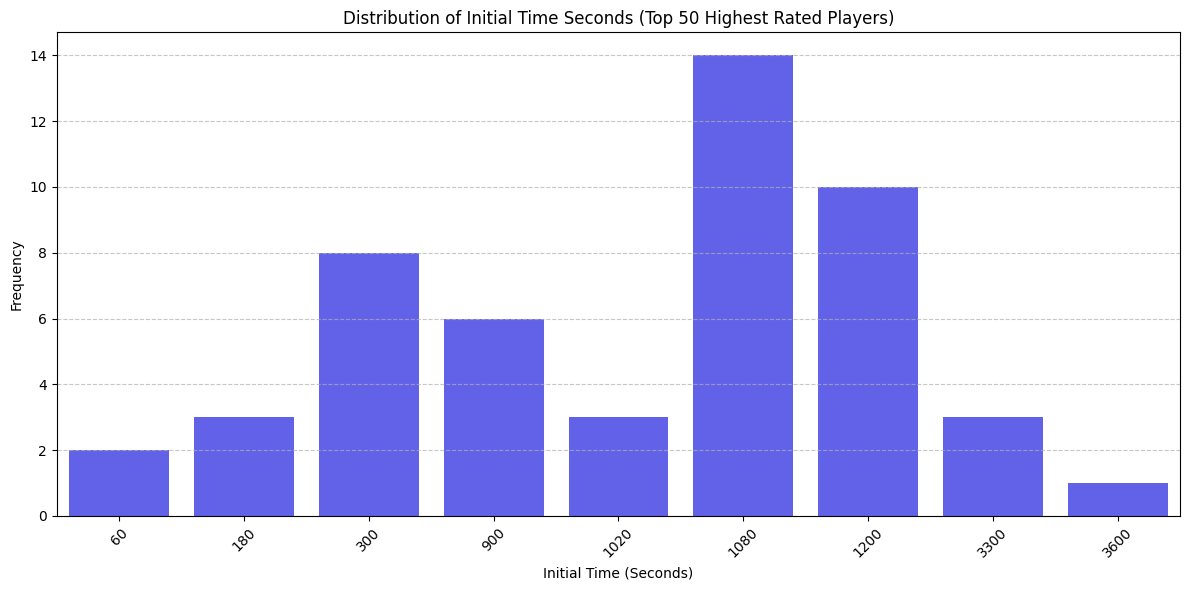

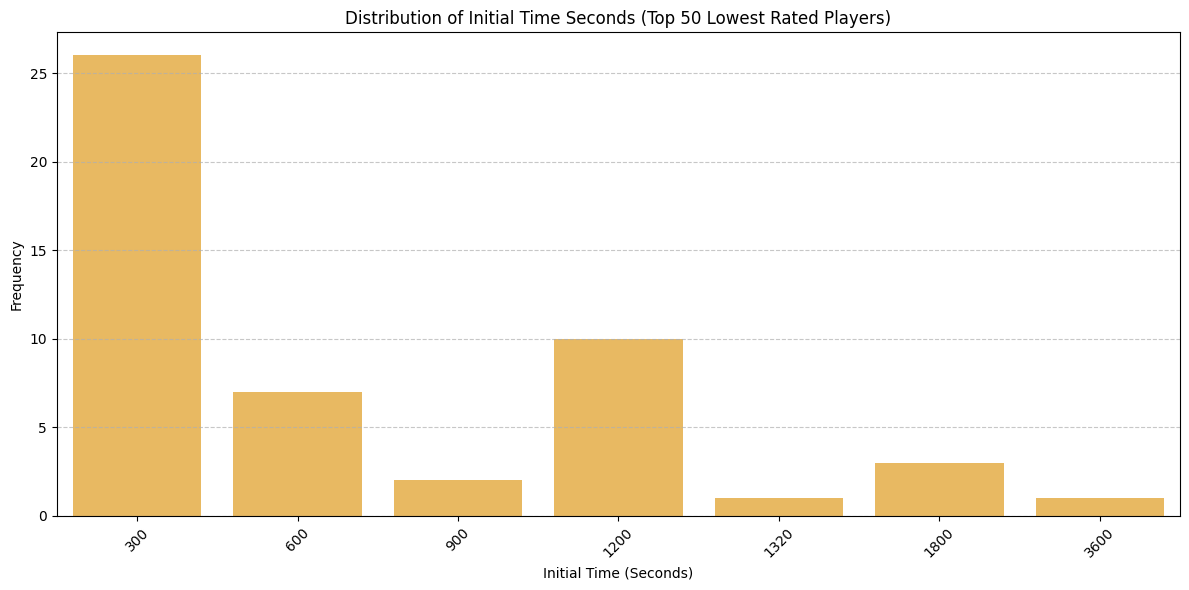

In [276]:
initial_time_seconds_distribution(50)

### Results for top 100 highest and lowest-rated players.

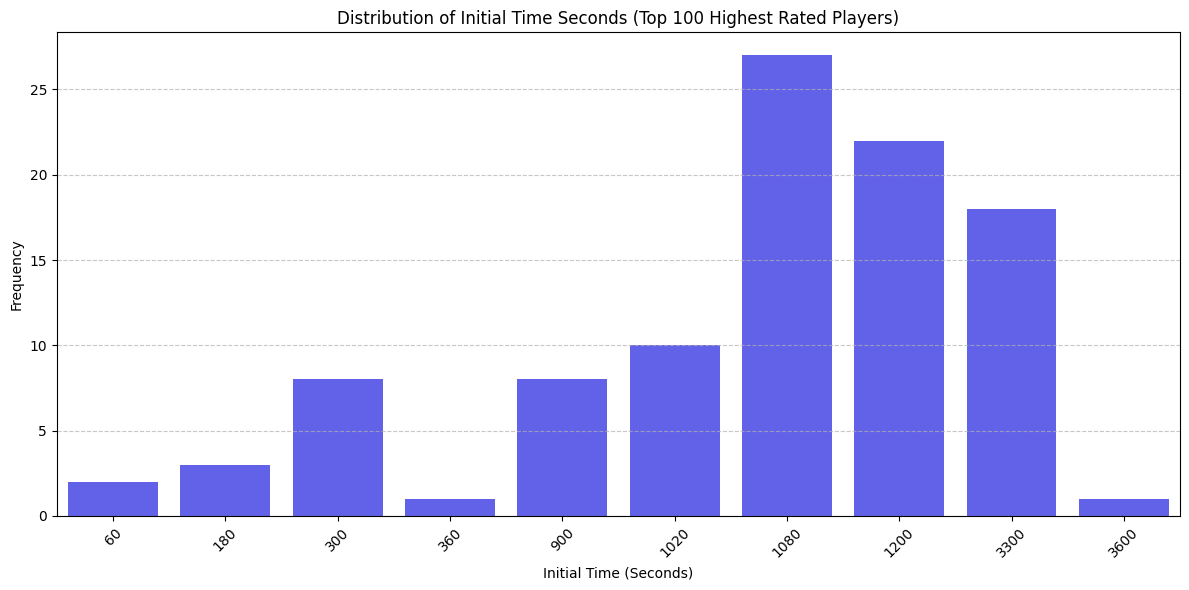

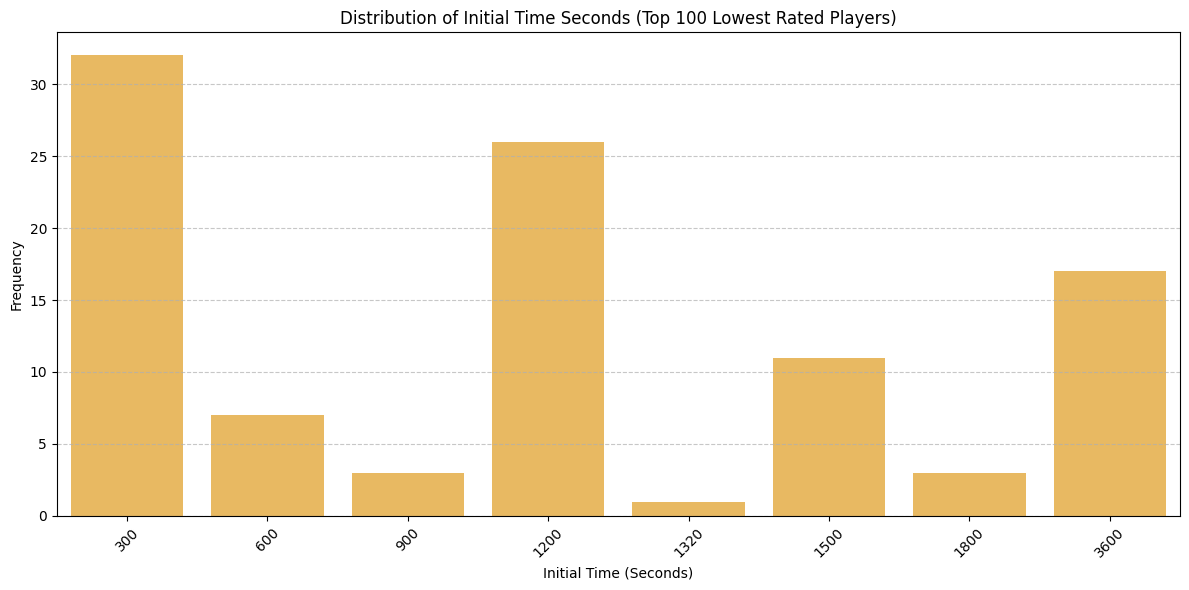

In [277]:
initial_time_seconds_distribution(100)

### Results for top 300 highest and lowest-rated players.

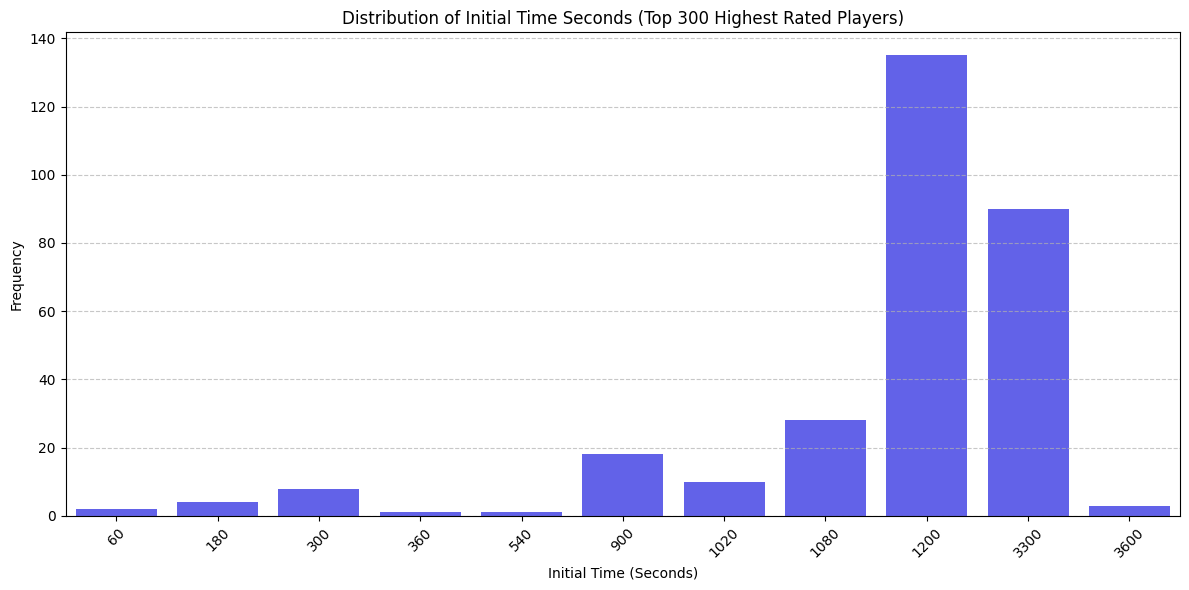

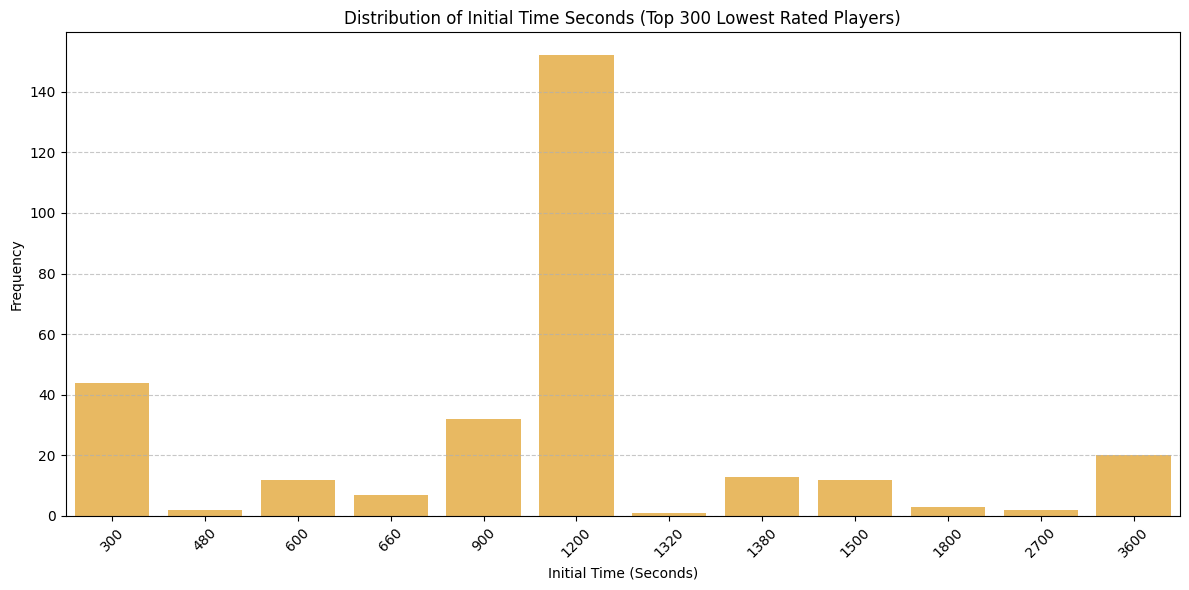

In [278]:
initial_time_seconds_distribution(300)

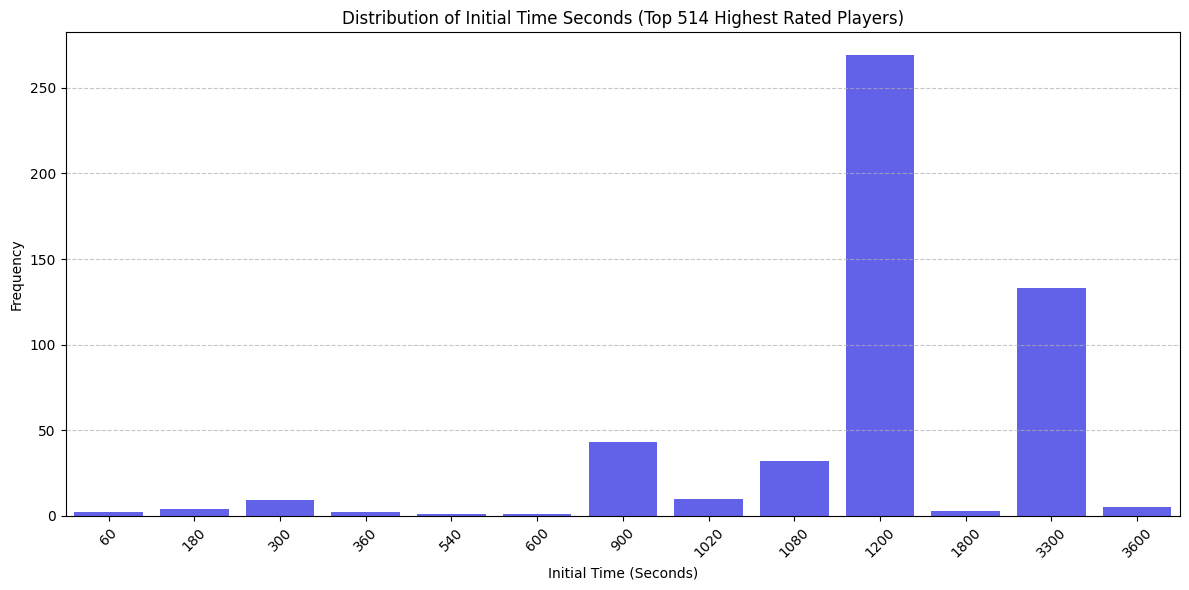

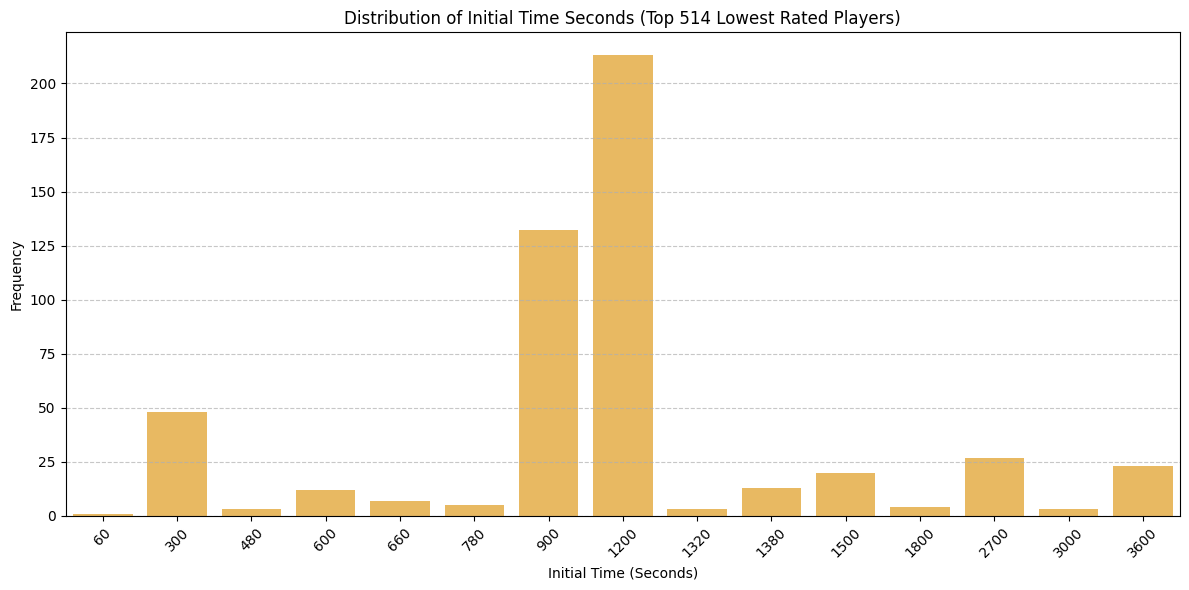

In [290]:
number_of_players =  train["user_name"].nunique()

initial_time_seconds_distribution(number_of_players // 2)

### Check correlation of categorial feature represent intial time

In [298]:
# Define the default initial time
default_time = 1200

temp = games.copy()

# Engineer the categorical feature for initial_time_seconds
temp["time_category"] = temp["initial_time_seconds"].apply(
    lambda x: "Shorter" if x < default_time else "Default" if x == default_time else "Longer"
)

# Merge the `games` and `train` datasets to align `time_category` with `user_rating`
temp_df = pd.merge(main_df, temp[["game_id", "time_category"]], on="game_id", how="inner")

# Encode the categorical `time_category` feature into numerical values for correlation calculation
time_category_mapping = {"Shorter": 0, "Default": 1, "Longer": 2}
temp_df["time_category_encoded"] = temp_df["time_category"].map(time_category_mapping)

# Calculate the correlation between `time_category_encoded` and `user_rating`
pearson_correlation = temp_df["time_category_encoded"].corr(temp_df["user_rating"], method="pearson")

# Display the correlation result
print(f"Correlation between 'time_category' and 'user_rating': {pearson_correlation:.2f}")

Correlation between 'time_category' and 'user_rating': 0.27


Numeric `initial_time_seconds` captures distinct player behaviors, such as high-ranked players favoring longer times and low-ranked players preferring shorter times. Retaining it preserves these nuances for the model to learn.


## Investigate

# Summarise datasets I got

## Train

In [282]:
display(train.head())

,game_id,bot_name,bot_score,bot_mean_rack_usage,bot_rating,user_name,user_score,user_mean_rack_usage,mean_average_letter_score,user_rating
0,1,BetterBot,335,0.700549,1637,stevy,429,0.573469,1.636905,1500
1,3,BetterBot,318,0.626374,2071,davidavid,440,0.591837,1.951531,1811
2,4,BetterBot,478,0.723810,1936,Inandoutworker,119,0.418367,1.202381,1473
3,5,STEEBot,427,0.659524,1844,stevy,325,0.511161,2.300000,1500
4,6,STEEBot,427,0.934066,2143,HivinD,378,0.678571,1.655556,2029


## Games

In [299]:
display(games.head())

,game_id,first,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds,bot_dificulity
0,1,BetterBot,regular,STANDARD,1,08/26/2022 3:38,NWL20,1200,0,CASUAL,1,674.844274,1
1,2,Super,regular,STANDARD,1,08/10/2022 19:19,CSW21,3600,0,RATED,1,364.214418,1
2,3,BetterBot,regular,STANDARD,1,09/04/2022 8:04,CSW21,900,0,RATED,5,492.268262,1
3,4,BetterBot,regular,RESIGNED,0,09/12/2022 2:36,CSW21,3600,0,CASUAL,1,350.861141,1
4,5,STEEBot,regular,STANDARD,0,09/06/2022 4:31,NWL20,1200,0,CASUAL,1,642.688722,2


## Turns

In [285]:
display(turns.head())

,game_id,turn_number,nickname,rack,location,move,points,score,turn_type,rack_len,rack_usage,letter_score,average_letter_score
0,1,1,BetterBot,DDEGITT,8G,DIG,10,10,Play,7.0,0.428571,5,1.666667
1,1,2,stevy,AEHOPUX,7H,HAP,18,18,Play,7.0,0.428571,8,2.666667
2,1,3,BetterBot,DEELTTU,6I,LUTE,16,26,Play,7.0,0.571429,4,1.000000
3,1,4,stevy,EMORSUX,5K,UM,16,34,Play,7.0,0.285714,4,2.000000
4,1,5,BetterBot,ACDEITU,L5,..DICATE,28,54,Play,7.0,1.142857,9,1.125000
